In [1]:
import os
import sys

BASE_DIR = os.path.dirname(os.path.abspath(""))

sys.path.append(BASE_DIR)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [4]:
from src.GPR_meta_mll import GPRegressionMetaLearned

In [5]:
from experiments.data_sim import SinusoidDataset

## Load data

In [6]:
data_sim = SinusoidDataset(random_state=np.random.RandomState(29))
meta_train_data = data_sim.generate_meta_train_data(n_tasks=20, n_samples=10)
meta_test_data = data_sim.generate_meta_test_data(n_tasks=50, n_samples_context=10, n_samples_test=160)

## Fit meta-GP model

In [7]:
meta_gp = GPRegressionMetaLearned(meta_train_data=meta_train_data)

In [8]:
meta_gp.meta_fit(valid_tuples=meta_test_data)

[2020-01-09 16:27:15,277 -INFO]  Iter 1/10000 - Loss: 0.600370 - Time 0.09 sec - Valid-LL: -1.407 - Valid-RMSE: 1.079 - Calib-Err 0.102
[2020-01-09 16:27:23,490 -INFO]  Iter 500/10000 - Loss: 0.497752 - Time 8.35 sec - Valid-LL: -1.241 - Valid-RMSE: 0.785 - Calib-Err 0.096
[2020-01-09 16:27:31,599 -INFO]  Iter 1000/10000 - Loss: 0.406006 - Time 8.00 sec - Valid-LL: -0.904 - Valid-RMSE: 0.448 - Calib-Err 0.145
[2020-01-09 16:27:39,402 -INFO]  Iter 1500/10000 - Loss: 0.249130 - Time 7.69 sec - Valid-LL: -0.612 - Valid-RMSE: 0.315 - Calib-Err 0.161
[2020-01-09 16:27:47,279 -INFO]  Iter 2000/10000 - Loss: 0.139729 - Time 7.79 sec - Valid-LL: -0.392 - Valid-RMSE: 0.293 - Calib-Err 0.141
[2020-01-09 16:27:55,173 -INFO]  Iter 2500/10000 - Loss: 0.054826 - Time 7.80 sec - Valid-LL: -0.209 - Valid-RMSE: 0.282 - Calib-Err 0.120
[2020-01-09 16:28:03,193 -INFO]  Iter 3000/10000 - Loss: -0.011192 - Time 7.94 sec - Valid-LL: -0.045 - Valid-RMSE: 0.266 - Calib-Err 0.107
[2020-01-09 16:28:11,401 -INFO

-0.26005834341049194

In [9]:
test_context_x, test_context_y, test_target_x, test_target_y = meta_test_data[0]

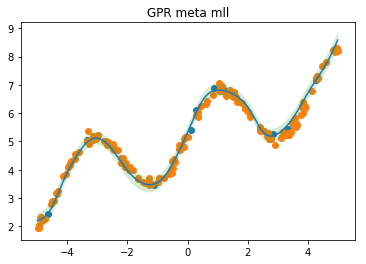

In [10]:
x_plot = np.linspace(-5, 5, num=150)
pred_mean, pred_std = meta_gp.predict(context_x=test_context_x, context_y=test_context_y, test_x=x_plot)
ucb, lcb = meta_gp.confidence_intervals(test_context_x, test_context_y, x_plot, confidence=0.9)

plt.scatter(test_context_x, test_context_y)
plt.scatter(test_target_x, test_target_y)

plt.plot(x_plot, pred_mean)
plt.fill_between(x_plot, lcb, ucb, alpha=0.2)
plt.title('GPR meta mll')
plt.show()

In [11]:
old_state = meta_gp.state_dict()

In [12]:
pred_mean, pred_std = meta_gp.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean - test_target_y.flatten())**2).mean()

0.030964940447804505

In [13]:
meta_gp = GPRegressionMetaLearned(meta_train_data=meta_train_data)

In [14]:
pred_mean, pred_std = meta_gp.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean - test_target_y.flatten())**2).mean()

2.718943802344488

In [15]:
meta_gp.load_state_dict(old_state)

In [16]:
pred_mean, pred_std = meta_gp.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean - test_target_y.flatten())**2).mean()

0.030964940447804505

## Build NP model

In [17]:
import time

from torch.distributions.kl import kl_divergence
from torch.utils.data import DataLoader

from third_party.neural_processes.utils import context_target_split
from third_party.neural_processes.training import NeuralProcessTrainer
from third_party.neural_processes.datasets import SineData
from third_party.neural_processes.neural_process import NeuralProcess

from src.models import LearnedGPRegressionModel, NeuralNetwork, AffineTransformedDistribution
from src.util import _handle_input_dimensionality, DummyLRScheduler
from src.abstract import RegressionModelMetaLearned
from config import device

%load_ext autoreload
%autoreload 2

In [20]:
class NPRegressionMetaLearned(RegressionModelMetaLearned):

    def __init__(self, meta_train_data, num_context, num_extra_target, lr_params=1e-3, r_dim=50, z_dim=50, h_dim=50, num_iter_fit=10000,
                 task_batch_size=5, normalize_data=True, optimizer='Adam', lr_decay=1.0, random_seed=None):
        """
        Neural Process regression model (https://arxiv.org/abs/1807.01622) that supports meta-learning.

        Args:
            meta_train_data: list of tuples of ndarrays[(train_x_1, train_t_1), ..., (train_x_n, train_t_n)]
            lr_params: (float) learning rate for prior parameters
            r_dim: (float) dimensionality of the context representation
            z_dim: (float) dimensionality of the latent variable
            h_dim: (float) layer width of encoder and decoder
            num_iter_fit: (int) number of gradient steps for fitting the parameters
            task_batch_size: (int) batch size for meta training, i.e. number of tasks for computing grads
            normalize_data: (bool) decides whether the input data should be normalized
            optimizer: (str) type of optimizer to use - must be either 'Adam' or 'SGD'
            lr_decay: (float) decay rate for the learning rate
            random_seed: (int) seed for pytorch
        """
        super().__init__(normalize_data, random_seed)

        assert optimizer in ['Adam', 'SGD']

        self.num_context, self.num_extra_target = num_context, num_extra_target
        self.lr_params, self.r_dim, self.z_dim, self.h_dim = lr_params, r_dim, z_dim, h_dim
        self.num_iter_fit, self.task_batch_size, self.normalize_data = num_iter_fit, task_batch_size, normalize_data

        # Check that data all has the same size
        self._check_meta_data_shapes(meta_train_data)
        self._compute_normalization_stats(meta_train_data)
        
        self.input_dim = meta_train_data[0][0].shape[-1]
        self.output_dim = meta_train_data[0][1].shape[-1]
        
        self.model = NeuralProcess(x_dim=self.input_dim,
                                  y_dim=self.output_dim,
                                  r_dim=self.r_dim,
                                  z_dim=self.z_dim,
                                  h_dim=self.h_dim)

        # Setup components that are shared across tasks
        self.shared_parameters = self.model.parameters()

        # Setup components that are different across tasks
        self.task_dicts = []

        for train_x, train_y in meta_train_data: # TODO: consider parallelizing this loop
            task_dict = {}
            
            if len(train_x) < 10:
                print(len(train_x))

            # a) prepare data
            x_tensor, y_tensor = self._prepare_data_per_task(train_x, train_y, flatten_y=False)
            task_dict['train_x'], task_dict['train_y'] = x_tensor, y_tensor

            self.task_dicts.append(task_dict)

        # c) prepare inference
        self._setup_optimizer(optimizer, lr_params, lr_decay)

        self.fitted = False


    def meta_fit(self, valid_tuples=None, verbose=True, log_period=500, n_iter=None):
        """
        fits the parameters of the Neural Process model

        Args:
            valid_tuples: list of valid tuples, i.e. [(test_context_x_1, test_context_t_1, test_x_1, test_t_1), ...]
            verbose: (boolean) whether to print training progress
            log_period: (int) number of steps after which to print stats
            n_iter: (int) number of gradient descent iterations
        """
        self.model.train()

        assert (valid_tuples is None) or (all([len(valid_tuple) == 4 for valid_tuple in valid_tuples]))

        t = time.time()
        cum_loss = 0.0

        if n_iter is None:
            n_iter = self.num_iter_fit

        for itr in range(1, n_iter + 1):

            loss = 0.0
            self.optimizer.zero_grad()
                
            batch = self.rds_numpy.choice(self.task_dicts, size=self.task_batch_size)
            batch_x = torch.stack([task["train_x"] for task in batch])
            batch_y = torch.stack([task["train_y"] for task in batch])
                        
            x_context, y_context, x_target, y_target = \
                context_target_split(batch_x, batch_y,
                                     self.num_context, self.num_extra_target)
            p_y_pred, q_target, q_context = \
                self.model(x_context, y_context, x_target, y_target)
            loss = self._loss(p_y_pred, y_target, q_target, q_context)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            cum_loss += loss

            # print training stats stats
            if itr == 1 or itr % log_period == 0:
                duration = time.time() - t
                avg_loss = cum_loss / (log_period if itr > 1 else 1.0)
                cum_loss = 0.0
                t = time.time()

                message = 'Iter %d/%d - Loss: %.6f - Time %.2f sec' % (itr, self.num_iter_fit, avg_loss.item(), duration)

                # if validation data is provided  -> compute the valid log-likelihood
                if valid_tuples is not None:
                    self.model.eval()
                    valid_ll, valid_rmse, calibr_err = self.eval_datasets(valid_tuples, flatten_y=False)
                    self.model.train()
                    message += ' - Valid-LL: %.3f - Valid-RMSE: %.3f - Calib-Err %.3f' % (valid_ll, valid_rmse, calibr_err)

                if verbose:
                    self.logger.info(message)


        self.fitted = True

        self.model.eval()
        return loss.item()

    
    def predict(self, context_x, context_y, test_x, return_density=False):
        """
        computes the predictive distribution of the targets p(t|test_x, test_context_x, context_y)

        Args:
            context_x: (ndarray) context input data for which to compute the posterior
            context_y: (ndarray) context targets for which to compute the posterior
            test_x: (ndarray) query input data of shape (n_samples, ndim_x)
            return_density: (bool) whether to return result as mean and std ndarray or as MultivariateNormal pytorch object

        Returns:
            (pred_mean, pred_std) predicted mean and standard deviation corresponding to p(t|test_x, test_context_x, context_y)
        """

        train_old = self.model.training
        self.model.eval()
        
        context_x, context_y = _handle_input_dimensionality(context_x, context_y)
        test_x = _handle_input_dimensionality(test_x)
        assert test_x.shape[1] == context_x.shape[1]

        # normalize data and convert to tensor
        context_x, context_y = self._prepare_data_per_task(context_x, context_y, flatten_y=False)

        test_x = self._normalize_data(X=test_x, Y=None)
        test_x = torch.from_numpy(test_x).float().to(device)
        
        context_x = torch.unsqueeze(context_x, 0)
        context_y = torch.unsqueeze(context_y, 0)
        test_x = torch.unsqueeze(test_x, 0)

        with torch.no_grad():
            # compute posterior given the context data
            pred_dist = self.model(context_x, context_y, test_x)
            pred_dist_transformed = AffineTransformedDistribution(pred_dist, normalization_mean=self.y_mean,
                                                                  normalization_std=self.y_std)            

        if train_old:
            self.model.train()
            
        if return_density:
            return pred_dist_transformed
        else:
            pred_mean = pred_dist_transformed.mean
            pred_std = pred_dist_transformed.stddev
            return pred_mean.cpu().numpy(), pred_std.cpu().numpy()

        
    def state_dict(self):
        state_dict = {
            'optimizer': self.optimizer.state_dict(),
            'model': self.model.state_dict()
        }
        for key, tensor in self.model.state_dict().items():
            assert torch.all(state_dict['model'][key] == tensor).item()
        return state_dict

    
    def load_state_dict(self, state_dict):
        self.model.load_state_dict(state_dict['model'])
        self.optimizer.load_state_dict(state_dict['optimizer'])
        
        
    def _loss(self, p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl
    

    def _setup_optimizer(self, optimizer, lr, lr_decay):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.AdamW(self.shared_parameters, lr=lr)
        elif optimizer == 'SGD':
            self.optimizer = torch.optim.SGD(self.shared_parameters, lr=lr)
        else:
            raise NotImplementedError('Optimizer must be Adam or SGD')

        if lr_decay < 1.0:
            self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1000, gamma=lr_decay)
        else:
            self.lr_scheduler = DummyLRScheduler()

    def _vectorize_pred_dist(self, pred_dist):
        return torch.distributions.Normal(pred_dist.mean, pred_dist.stddev)

In [21]:
meta_np = NPRegressionMetaLearned(meta_train_data=meta_train_data, num_context=5, num_extra_target=5)
meta_np.meta_fit(valid_tuples=meta_test_data)

[2020-01-09 16:35:57,098 -INFO]  Iter 1/10000 - Loss: 10.506763 - Time 0.01 sec - Valid-LL: -0.013 - Valid-RMSE: 1.642 - Calib-Err 0.567
[2020-01-09 16:35:59,729 -INFO]  Iter 500/10000 - Loss: 8.391348 - Time 2.66 sec - Valid-LL: -0.007 - Valid-RMSE: 0.776 - Calib-Err 0.566
[2020-01-09 16:36:02,180 -INFO]  Iter 1000/10000 - Loss: 6.318030 - Time 2.43 sec - Valid-LL: -0.007 - Valid-RMSE: 0.722 - Calib-Err 0.566
[2020-01-09 16:36:04,892 -INFO]  Iter 1500/10000 - Loss: 3.905104 - Time 2.70 sec - Valid-LL: -0.004 - Valid-RMSE: 0.498 - Calib-Err 0.566
[2020-01-09 16:36:07,555 -INFO]  Iter 2000/10000 - Loss: -0.677310 - Time 2.64 sec - Valid-LL: -0.003 - Valid-RMSE: 0.370 - Calib-Err 0.566
[2020-01-09 16:36:10,455 -INFO]  Iter 2500/10000 - Loss: -2.954686 - Time 2.88 sec - Valid-LL: -0.003 - Valid-RMSE: 0.326 - Calib-Err 0.566
[2020-01-09 16:36:13,132 -INFO]  Iter 3000/10000 - Loss: -3.575552 - Time 2.66 sec - Valid-LL: -0.002 - Valid-RMSE: 0.294 - Calib-Err 0.566
[2020-01-09 16:36:15,752 -I

-9.42683219909668

In [22]:
test_context_x, test_context_y, test_target_x, test_target_y = meta_test_data[0]

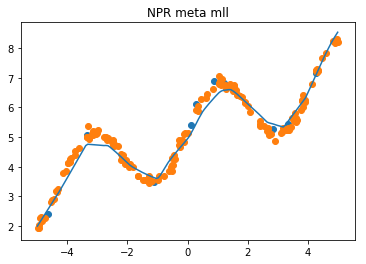

In [23]:
x_plot = np.linspace(-5, 5, num=150)
x_plot = x_plot[:, np.newaxis]
pred_mean, pred_std = meta_np.predict(context_x=test_context_x, context_y=test_context_y, test_x=x_plot)
ucb, lcb = meta_np.confidence_intervals(test_context_x, test_context_y, x_plot, confidence=0.9)

plt.scatter(test_context_x, test_context_y)
plt.scatter(test_target_x, test_target_y)

plt.plot(x_plot.flatten(), pred_mean.flatten())
# plt.fill_between(x_plot, lcb, ucb, alpha=0.2)
plt.title('NPR meta mll')
plt.show()

In [24]:
old_state = meta_np.state_dict()

In [25]:
pred_mean, pred_std = meta_np.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean.flatten() - test_target_y.flatten())**2).mean()

0.10131026864439921

In [26]:
meta_np = NPRegressionMetaLearned(meta_train_data=meta_train_data, num_context=5, num_extra_target=5)
meta_np.model.eval();

In [27]:
pred_mean, pred_std = meta_np.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean.flatten() - test_target_y.flatten())**2).mean()

1.952321980005579

In [28]:
meta_np.load_state_dict(old_state)

In [29]:
pred_mean, pred_std = meta_np.predict(context_x=test_context_x, context_y=test_context_y, test_x=test_target_x)

((pred_mean.flatten() - test_target_y.flatten())**2).mean()

0.11963868226808042